# Lesson 10 - Sentiment Analysis

## Author - AlexSkrn

This assignment requires that you build a sentiment analysis classifier for a series of tweets.
The data consists of a file "twitter_data.csv". The file contains 160,000 tweets with their respective score. The attributes are the sentences, and the score is either 4 (for positive) or 0 (for negative).

Assignment Instructions
1. Complete all questions below.
2. Comment on the applicability of the model on future tweets.  

### Note: This solution is mostly copy-pasted from the lesson 10 materials, with very minor modifications. I asked the group in the code talk section what they thought about this but no one commented. 

In [1]:
#Imports
import matplotlib.pyplot as plt
import pandas
import string
import re
import numpy as np

from scipy.sparse import coo_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords

%matplotlib inline

In [2]:
#Read files
url = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/twitter_data.csv"
df = pandas.read_csv(url, sep=",")
df.columns = ["sentiment_label","tweet_text"]
    
print(df.head())


   sentiment_label                                         tweet_text
0                4  @elephantbird Hey dear, Happy Friday to You  A...
1                4  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...


In [3]:
def preprocess(text, list_of_steps):
    """Return a string cleaned up as per the list of steps."""
    for step in list_of_steps:
        if step == 'remove_non_ascii':
            text = ''.join([x for x in text if ord(x) < 128])
        elif step == 'lowercase':
            text = text.lower()
        elif step == 'remove_punctuation':
            punct_exclude = set(string.punctuation)
            text = ''.join(char for char in text if char not in punct_exclude)
        elif step == 'remove_numbers':
            text = re.sub("\d+", "", text)
        elif step == 'strip_whitespace':
            text = ' '.join(text.split())
        elif step == 'remove_stopwords':
            stops = stopwords.words('english')
            word_list = text.split(' ')
            text_words = [word for word in word_list if word not in stops]
            text = ' '.join(text_words)
        elif step == 'stem_words':
            lmtzr = WordNetLemmatizer()
            word_list = text.split(' ')
            stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
            text = ' '.join(stemmed_words)
    return text

In [4]:
# Sentiment is either '4' or '0'. Change to '1' or '0' to indicate positive or negative sentiment.
df.sentiment_label = df.sentiment_label.replace(4,1)

In [5]:
# Convert a copy of the tweets as list for use later
tweet_data = df.values.tolist()

In [6]:
# Clean tweets
steps = ['lowercase', 'remove_punctuation', 'remove_numbers', 'strip_whitespace', 'remove_stopwords']

df['clean_tweet'] = df['tweet_text'].map(lambda s: preprocess(s, steps))

In [7]:
# Create a document storage matrix
clean_texts = df['clean_tweet']
docs = {}
labels = []
for ix, row in enumerate(clean_texts):
    # Store the sentiment
    labels = tweet_data[ix][0]
    docs[ix] = row.split(' ')

# See a sample
print('Example entry: {}'.format(docs[np.random.choice(ix)]))

Example entry: ['mandyalwaysknws', 'sad', 'day']


In [8]:
# Keep track of how many unique words there are:
num_nonzero = 0
vocab = set()

for word_list in docs.values():
    unique_terms = set(word_list)    # all unique terms of this tweet
    vocab.update(unique_terms)       # set union: add unique terms of this tweet
    num_nonzero += len(unique_terms) # add count of unique terms in this tweet

doc_key_list = list(docs.keys())

print('Our tweet-vocabulary has {} distinct words.'.format(len(vocab)))

Our tweet-vocabulary has 151526 distinct words.


In [9]:
# Convert everything to a numpy array:
doc_key_list = np.array(doc_key_list)
vocab = np.array(list(vocab))

In [10]:
# Keep track of how the vocab/term indices map to the matrix so that we can look them up later.
vocab_sorter = np.argsort(vocab)

print('Vocab: {}'.format(vocab[:5]))
print('Sorted Vocab: {}'.format(vocab[vocab_sorter[:5]]))

Vocab: ['' 'brewin' 'lolatleast' 'wickets' 'lbegleykorth']
Sorted Vocab: ['' 'aa' 'aaa' 'aaaa' 'aaaaa']


In [11]:
# Initialize our sparse matrix:
num_docs = len(doc_key_list)
vocab_size = len(vocab)
# A COO matrix is just a tuple of data, row indices, and column indices. Everything else is assumed to be zero.
data = np.empty(num_nonzero, dtype=np.intc)     # all non-zero
rows = np.empty(num_nonzero, dtype=np.intc)     # row index
cols = np.empty(num_nonzero, dtype=np.intc)     # column index

In [12]:
ix = 0
# go through all documents with their terms
print('Computing full term-document matrix (sparse), please wait!')
for doc_key, terms in docs.items():
    # find indices to insert-into such that, if the corresponding elements were
    # inserted before the indices, the order would be preserved
    term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter=vocab_sorter)]

    # count the unique terms of the document and get their vocabulary indices
    uniq_indices, counts = np.unique(term_indices, return_counts=True)
    n_vals = len(uniq_indices)  # = number of unique terms
    ix_end = ix + n_vals # Add count to index.

    data[ix:ix_end] = counts                  # save the counts (term frequencies)
    cols[ix:ix_end] = uniq_indices            # save the column index: index in 
    doc_ix = np.where(doc_key_list == doc_key)   # get the document index for the document name
    rows[ix:ix_end] = np.repeat(doc_ix, n_vals)  # save it as repeated value

    ix = ix_end  # resume with next document -> will add future data on the end.
print('Done!')

Computing full term-document matrix (sparse), please wait!
Done!


In [13]:
# Create the sparse matrix
doc_term_mat = coo_matrix((data, (rows, cols)), shape=(num_docs, vocab_size), dtype=np.intc)

In [14]:
# Trimming the Doc-term matrix
# Look at how many words are above a specific cutoff
word_counts = doc_term_mat.sum(axis=0)
cutoff = 15
word_count_list = word_counts.tolist()[0]
# Find which column indices are above cutoff
col_cutoff_ix = [ix for ix, count in enumerate(word_count_list) if count > cutoff]

print('Number of words w/counts above {} : {}'.format(cutoff, len(col_cutoff_ix)))

Number of words w/counts above 15 : 6095


In [15]:
# Get the trimmed vocabulary
vocab_trimmed = np.array([vocab[x] for x in col_cutoff_ix])
# Re-do the vocab-sorter
vocab_sorter_trimmed = np.argsort(vocab_trimmed)

print('Shape of document-term matrix before trimming: {}'.format(doc_term_mat.shape))

# Trim the document-term matrix
doc_term_mat_trimmed = doc_term_mat.tocsc()[:,col_cutoff_ix]

print('Shape of document-term matrix after trimming: {}'.format(doc_term_mat_trimmed.shape))

Shape of document-term matrix before trimming: (160000, 151526)
Shape of document-term matrix after trimming: (160000, 6095)


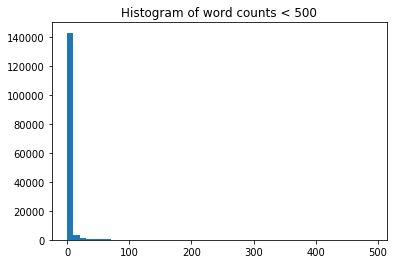

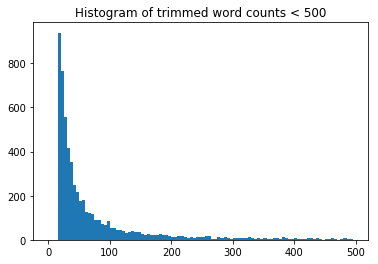

In [16]:
# Count of words for each appearance
hist_breaks = np.arange(0, 500, 10)
plt.hist(word_count_list, bins = hist_breaks)
plt.title('Histogram of word counts < 500')
plt.show()

# Too many words appear few times. Check out trimmed.
trimmed_word_counts = doc_term_mat_trimmed.sum(axis=0)
trimmed_word_list = trimmed_word_counts.tolist()[0]
hist_breaks = np.arange(0, 500, 5)
plt.hist(trimmed_word_list, bins = hist_breaks)
plt.title('Histogram of trimmed word counts < 500')
plt.show()

In [17]:
# Declare the TFIDF vectorizer.
vectorizer = TfidfVectorizer(sublinear_tf=True,
                             max_df=0.5,
                             max_features=len(col_cutoff_ix),
                             stop_words='english')

# Fit the vectorizer over the dataset
clean_texts = df['clean_tweet']
tf_idf_tweets = vectorizer.fit_transform(clean_texts)

Q1: Generate word cloud for positive sentiment.

<b>A TF-IDF features matrix is prepared above for the data covering both sentiments.</b>

Q2: Generate word cloud for negative sentiment.

<b>A TF-IDF features matrix is prepared above for the data covering both sentiments.</b>

Q3: Split data into 70% for training and 30% for testing.

In [18]:
# For training: 107,000 tweets to predict the 0,1 sentiment. 
# The remaining 53,000 cases to evaluate the model.
print('Splitting into train-test. Please wait!')
y_targets = np.array([y[0] for y in tweet_data])
# Generate 53,000 random row indices
X_train, X_test, y_train, y_test = train_test_split(tf_idf_tweets,
                                                    y_targets,
                                                    test_size=53000,
                                                    random_state=42)
print('Done!')

Splitting into train-test. Please wait!
Done!


Q4: Build a classifier that classifies the sentiment of a sentence.

In [19]:
# train a logistic classifier on the data
print('Starting a standard Logistic Model training!')
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('Done.')

Starting a standard Logistic Model training!


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Done.


Q5: What is the accuracy of your model when applied to testing data?

In [20]:
## Compute results on the train and test set
train_probs = lr.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = lr.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

In [21]:
# Compute accuracies
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

Train accuracy: 0.7813831775700935
Test accuracy: 0.7545660377358491


In [22]:
# Precision is the proportion of correct predictions among all predicted
# Recall (sensitivity) is the proportion of correct predictions among all true actual examples
# F1 is the harmonic average of precision and recall
# Support is count of actual cases of specific class
# Here, each of the following is a pair of numbers, the first is for class 1 ('1') and second for class 0 ('0')
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_results)

# Get the parts of the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_results).ravel()

# Print results
print(confusion_matrix(y_test, test_results))
print('='*35)
print('             Class 1   -   Class 0')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

[[19298  7283]
 [ 5725 20694]]
             Class 1   -   Class 0
Precision: [0.77121049 0.73967902]
Recall   : [0.7260073 0.7832999]
F1       : [0.74792652 0.76086477]
Support  : [26581 26419]


In [23]:
# An attempt to improve the results with regularization
# to get rid of the discrepancy between train accuracy and test accuracy

print('Starting training regularized logistic regression')
from sklearn.linear_model import SGDClassifier
lr_reg = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15)
lr_reg.fit(X_train, y_train)
print('Done!')

Starting training regularized logistic regression
Done!


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [24]:
## Compute results on the train and test set
train_probs = lr_reg.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = lr_reg.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

In [25]:
# Compute accuracies
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

Train accuracy: 0.7540654205607477
Test accuracy: 0.7462452830188679


In [26]:
# Precision is the proportion of correct predictions among all predicted
# Recall (sensitivity) is the proportion of correct predictions among all true actual examples
# F1 is the harmonic average of precision and recall
# Support is count of actual cases of specific class
# Here, each of the following is a pair of numbers, the first is for class 1 ('1') and second for class 0 ('0')
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_results)

# Get the parts of the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_results).ravel()

# Print results
print(confusion_matrix(y_test, test_results))
print('='*35)
print('             Class 1   -   Class 0')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

[[18872  7709]
 [ 5740 20679]]
             Class 1   -   Class 0
Precision: [0.76678043 0.7284416 ]
Recall   : [0.70998081 0.78273212]
F1       : [0.7372883  0.75461164]
Support  : [26581 26419]


Q6: What conclusions can you draw from the model?

<b>From the results of the model, I conclude that its predictive ability doesn't look good, with the proportion of misclassified sentiments being almost 30%.</b>

Q7: Is it better to have a model per source?

<b>I don't understand what 'source' means here, but I will assume that a 'source' is the domain from which the data is sourced and used to train the model. In such case, the obvious answer would be yes, it is the only way. A model should be trained, tested and used on the data from the same domain (or source), otherwise it will not be able to make accurate predictions because it is not possible to predict market prices for oil by a model trained on movie reviews.</b>

### Comment on the applicability of the model on future tweets

Given the overall inaccuracy of the model, I am pessimistic about its usefulness for predicting sentiments in future tweets. The model might probably be used for aggregate predictions, for example, along the lines that a larger amount of tweets seems to be positive.  